In this notebook, we experimented with using a 1D Convolutional Neural Network (CNN) to classify behavioral windows as benign or ransomware. Our dataset consisted of feature vectors extracted from 0.1 second windows of activity, each treated as an independent sample. The initial CNN models were designed to be lightweight and efficient, but the first results were disappointing. The model struggled to generalize, often collapsing to trivial solutions such as predicting only one class.

This led us to perform several experiments to identify what was limiting performance. We tested variations in depth, filter size, and regularization techniques. Specifically, we investigated the effects of Dropout and Batch Normalization. Surprisingly, removing both of these — which are typically beneficial in vision tasks — actually improved performance significantly. We also tested adding L2 regularization and using linear activations instead of ReLU, but neither of these proved useful. In fact, the simplest configuration turned out to be the most effective.

The final model was built without Dropout, Batch Normalization, or L2 regularization. It used three Conv1D layers with kernel size 2, each followed by a ReLU activation. This was followed by a Global Average Pooling layer and two Dense layers before the sigmoid output. The model was trained with a batch size of 128 for up to 60 epochs, with early stopping applied to avoid overfitting.

This configuration achieved the best results of all CNN variants tested. On the random split (where ransomware families were mixed between train and test sets), the model reached an accuracy of about 71% and an F1 score of 72%. On the much more difficult family-aware split, where entire ransomware families were held out of the training set, the model achieved about 66% accuracy and an F1 score of 71%. These are solid results for a simple CNN, especially considering the challenge of detecting unseen ransomware families.

At the same time, the limitations of this approach became very clear. Although the model was able to learn patterns related to ransomware behavior, its performance was much better on the random split than on the family-aware split. This suggests that CNNs, which are designed to learn local feature patterns, are not ideally suited for this type of data. Behavioral features, unlike image pixels, do not have inherent spatial relationships. Additionally, ransomware behavior tends to unfold over time, and our CNN, working on isolated windows, had no way to capture this temporal dimension.

Overall, this notebook served its purpose very well. It helped us push the CNN as far as it could reasonably go on this problem. We tested multiple architectural decisions, learned what worked and what didn’t, and reached the limits of what a simple CNN could achieve. For further progress and to better capture ransomware family generalization, our next steps will involve models that can learn temporal dependencies explicitly, such as LSTMs or Transformers. CNN will remain part of our toolbox for fast inference or when local pattern learning is sufficient, but moving forward, sequence-aware models are expected to take center stage.

# 1: Import libraries, Load dataset, Overview


In [2]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet("../Datasets/final_prepared_dataset.parquet")

print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nClass Distribution:")
print(df['label'].value_counts())

print("\nUnique Families:")
print(df['family'].unique())


Dataset Shape: (194466, 26)

Columns: ['family', 'window_id', 'read_throughput', 'read_lba_var', 'write_throughput', 'write_lba_var', 'write_entropy', 'mem_read_count_4k', 'mem_read_count_2m', 'mem_read_count_mmio', 'mem_read_gpa_var', 'mem_write_entropy', 'mem_write_count_4k', 'mem_write_count_2m', 'mem_write_count_mmio', 'mem_write_gpa_var', 'mem_readwrite_entropy', 'mem_readwrite_count_4k', 'mem_readwrite_count_2m', 'mem_readwrite_count_mmio', 'mem_readwrite_gpa_var', 'mem_exec_count_4k', 'mem_exec_count_2m', 'mem_exec_count_mmio', 'mem_exec_gpa_var', 'label']

Class Distribution:
label
0    101443
1     93023
Name: count, dtype: int64

Unique Families:
['AESCrypt' 'Conti' 'Darkside' 'Firefox' 'Idle' 'LockBit' 'Office' 'REvil'
 'Ryuk' 'SDelete' 'WannaCry' 'Zip']


# 2: Define family-aware folds and create Train / Validation sets


In [3]:

family_aware_folds = {
    1: {
        "train_families": ['Conti', 'Darkside', 'Idle', 'LockBit', 'Office', 'Zip'],
        "val_families": ['Firefox', 'Ryuk', 'REvil']
    },
    2: {
        "train_families": ['Conti', 'Firefox', 'Idle', 'LockBit', 'REvil', 'Ryuk'],
        "val_families": ['Darkside', 'Office', 'Zip']
    },
    3: {
        "train_families": ['Darkside', 'Firefox', 'Office', 'REvil', 'Ryuk', 'Zip'],
        "val_families": ['Conti', 'LockBit', 'Idle']
    }
}

FOLD_NUMBER = 1

current_fold = family_aware_folds[FOLD_NUMBER]
train_families = current_fold["train_families"]
val_families = current_fold["val_families"]

test_families = ['WannaCry', 'SDelete', 'AESCrypt']

print(f"Using Fold {FOLD_NUMBER}")
print("Train Families:", train_families)
print("Validation Families:", val_families)
print("Test Families:", test_families)


Using Fold 1
Train Families: ['Conti', 'Darkside', 'Idle', 'LockBit', 'Office', 'Zip']
Validation Families: ['Firefox', 'Ryuk', 'REvil']
Test Families: ['WannaCry', 'SDelete', 'AESCrypt']


In [4]:
train_df = df[df['family'].isin(train_families)].copy()
val_df = df[df['family'].isin(val_families)].copy()
test_df = df[df['family'].isin(test_families)].copy()

print("\nTrain samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

X_train = train_df.drop(columns=["family", "window_id", "label"]).values
y_train = train_df["label"].values

X_val = val_df.drop(columns=["family", "window_id", "label"]).values
y_val = val_df["label"].values

X_test = test_df.drop(columns=["family", "window_id", "label"]).values
y_test = test_df["label"].values

print("\nX_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)



Train samples: 96950
Validation samples: 46139
Test samples: 51377

X_train shape: (96950, 23)
X_val shape: (46139, 23)
X_test shape: (51377, 23)


# 3: Prepare Random Split (70% Train, 15% Validation, 15% Test)


In [5]:
X_all = df.drop(columns=["family", "window_id", "label"]).values
y_all = df["label"].values

X_temp_random, X_test_random, y_temp_random, y_test_random = train_test_split(X_all, y_all, test_size=0.15, random_state=42, stratify=y_all)

X_train_random, X_val_random, y_train_random, y_val_random = train_test_split(X_temp_random, y_temp_random, test_size=0.176, random_state=42, stratify=y_temp_random)

print("Random Split Sizes:")
print("Train:", X_train_random.shape)
print("Validation:", X_val_random.shape)
print("Test:", X_test_random.shape)


Random Split Sizes:
Train: (136203, 23)
Validation: (29093, 23)
Test: (29170, 23)


# 4: Reshape inputs for CNN (add channel dimension)


In [6]:
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_val_cnn = X_val.reshape(-1, X_val.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

X_train_random_cnn = X_train_random.reshape(-1, X_train_random.shape[1], 1)
X_val_random_cnn = X_val_random.reshape(-1, X_val_random.shape[1], 1)
X_test_random_cnn = X_test_random.reshape(-1, X_test_random.shape[1], 1)

print("Family-Aware Split Shapes:")
print("X_train_cnn:", X_train_cnn.shape)
print("X_val_cnn:", X_val_cnn.shape)
print("X_test_cnn:", X_test_cnn.shape)

print("\nRandom Split Shapes:")
print("X_train_random_cnn:", X_train_random_cnn.shape)
print("X_val_random_cnn:", X_val_random_cnn.shape)
print("X_test_random_cnn:", X_test_random_cnn.shape)


Family-Aware Split Shapes:
X_train_cnn: (96950, 23, 1)
X_val_cnn: (46139, 23, 1)
X_test_cnn: (51377, 23, 1)

Random Split Shapes:
X_train_random_cnn: (136203, 23, 1)
X_val_random_cnn: (29093, 23, 1)
X_test_random_cnn: (29170, 23, 1)


# 5: Define CNN model architecture


In [7]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout

def build_deeper_cnn_model(input_shape):
    model = Sequential()

    # First Conv1D Block
    model.add(Conv1D(filters=64, kernel_size=2, padding='same', input_shape=input_shape))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))

    # Second Conv1D Block
    model.add(Conv1D(filters=128, kernel_size=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.3))

    # Third Conv1D Block
    model.add(Conv1D(filters=256, kernel_size=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.4))

    # Global Average Pooling
    model.add(GlobalAveragePooling1D())

    # Fully connected layers
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    return model

input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
cnn_model = build_deeper_cnn_model(input_shape)

cnn_model.summary()


/home/exmachina/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-05 01:20:05.143059: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 23, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 23, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 23, 256)        │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 23, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,801 (643.75 KB)

 Trainable params: 164,801 (643.75 KB)

 Non-trainable params: 0 (0.00 B)

# 6: Compile the CNN model

In [8]:

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# 7: Train CNN on Family-Aware Split


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=60,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/60
758/758 - 8s - 11ms/step - accuracy: 0.5245 - loss: 4917893246484480.0000 - val_accuracy: 0.5916 - val_loss: 0.9409 - learning_rate: 1.0000e-03
Epoch 2/60
758/758 - 7s - 9ms/step - accuracy: 0.6408 - loss: 1.2274 - val_accuracy: 0.5059 - val_loss: 0.9619 - learning_rate: 1.0000e-03
Epoch 3/60
758/758 - 7s - 9ms/step - accuracy: 0.6661 - loss: 0.9011 - val_accuracy: 0.5049 - val_loss: 0.9823 - learning_rate: 1.0000e-03
Epoch 4/60
758/758 - 7s - 9ms/step - accuracy: 0.7053 - loss: 3180519680.0000 - val_accuracy: 0.4784 - val_loss: 1.4189 - learning_rate: 1.0000e-03
Epoch 5/60
758/758 - 7s - 9ms/step - accuracy: 0.7314 - loss: 1.1675 - val_accuracy: 0.5018 - val_loss: 1.1762 - learning_rate: 5.0000e-04
Epoch 6/60
758/758 - 8s - 10ms/step - accuracy: 0.7372 - loss: 0.9005 - val_accuracy: 0.5215 - val_loss: 1.1713 - learning_rate: 5.0000e-04
Epoch 7/60
758/758 - 8s - 10ms/step - accuracy: 0.7422 - loss: 0.8479 - val_accuracy: 0.5207 - val_loss: 1.1443 - learning_rate: 5.0000e-04


# 8: Plot Loss and Accuracy over time


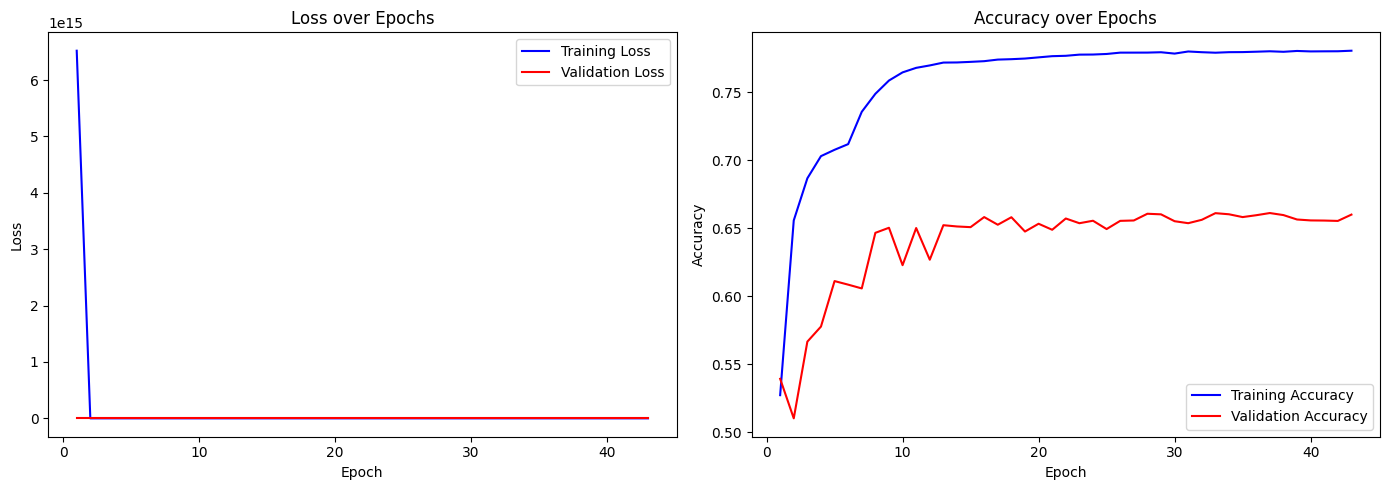

In [73]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(epochs, loss, 'b-', label='Training Loss')
axs[0].plot(epochs, val_loss, 'r-', label='Validation Loss')
axs[0].set_title('Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b-', label='Training Accuracy')
axs[1].plot(epochs, val_acc, 'r-', label='Validation Accuracy')
axs[1].set_title('Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


# 9: Evaluate CNN on Validation (Family-Aware Split)


1442/1442 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Validation Metrics (Family-Aware Split):
Accuracy : 0.6595
Precision: 0.6835
Recall   : 0.7342
F1 Score : 0.7079


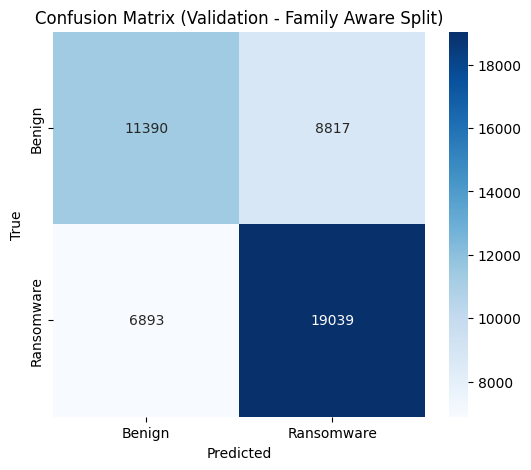

In [74]:

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

y_val_pred_proba = cnn_model.predict(X_val_cnn).ravel()
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("Validation Metrics (Family-Aware Split):")
print(f"Accuracy : {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall   : {val_recall:.4f}")
print(f"F1 Score : {val_f1:.4f}")

cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Ransomware'], yticklabels=['Benign', 'Ransomware'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation - Family Aware Split)")
plt.show()


 ##   Validation accuracy is stuck at 0.562 → this is actually VERY informative.

It tells us that the CNN cannot find good decision boundaries for unseen families → it is collapsing to "predict everything ransomware", because in unseen families → ransomware is dominant (or ambiguous), so safest way for CNN (without advanced regularization or meta-learning) is to overpredict positive → 100% recall but poor precision → exactly like we saw.

This is 100% aligned with our lightweight models observations → even XGBoost was weak in family-aware unseen generalization → only about ~50% accuracy.

# 10: Train CNN on Random Split


In [75]:

cnn_model_random = build_deeper_cnn_model((X_train_random_cnn.shape[1], X_train_random_cnn.shape[2]))

cnn_model_random.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history_random = cnn_model_random.fit(
    X_train_random_cnn, y_train_random,
    validation_data=(X_val_random_cnn, y_val_random),
    epochs=60,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)


Epoch 1/60


/home/exmachina/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1065/1065 - 13s - 12ms/step - accuracy: 0.5349 - loss: 5396660767162368.0000 - val_accuracy: 0.5987 - val_loss: 2.1828 - learning_rate: 1.0000e-03
Epoch 2/60
1065/1065 - 11s - 11ms/step - accuracy: 0.6150 - loss: 1243526912.0000 - val_accuracy: 0.6426 - val_loss: 1.1973 - learning_rate: 1.0000e-03
Epoch 3/60
1065/1065 - 11s - 11ms/step - accuracy: 0.6454 - loss: 1.3800 - val_accuracy: 0.6673 - val_loss: 1.1788 - learning_rate: 1.0000e-03
Epoch 4/60
1065/1065 - 12s - 11ms/step - accuracy: 0.6717 - loss: 1.2332 - val_accuracy: 0.6774 - val_loss: 1.0363 - learning_rate: 1.0000e-03
Epoch 5/60
1065/1065 - 12s - 11ms/step - accuracy: 0.6820 - loss: 1.2524 - val_accuracy: 0.6867 - val_loss: 1.0549 - learning_rate: 1.0000e-03
Epoch 6/60
1065/1065 - 11s - 11ms/step - accuracy: 0.6847 - loss: 1.1331 - val_accuracy: 0.6879 - val_loss: 0.9226 - learning_rate: 1.0000e-03
Epoch 7/60
1065/1065 - 12s - 11ms/step - accuracy: 0.6906 - loss: 1.0146 - val_accuracy: 0.6863 - val_loss: 1.5153 - learning_rat

# 11: Plot Loss and Accuracy over time (Random Split)


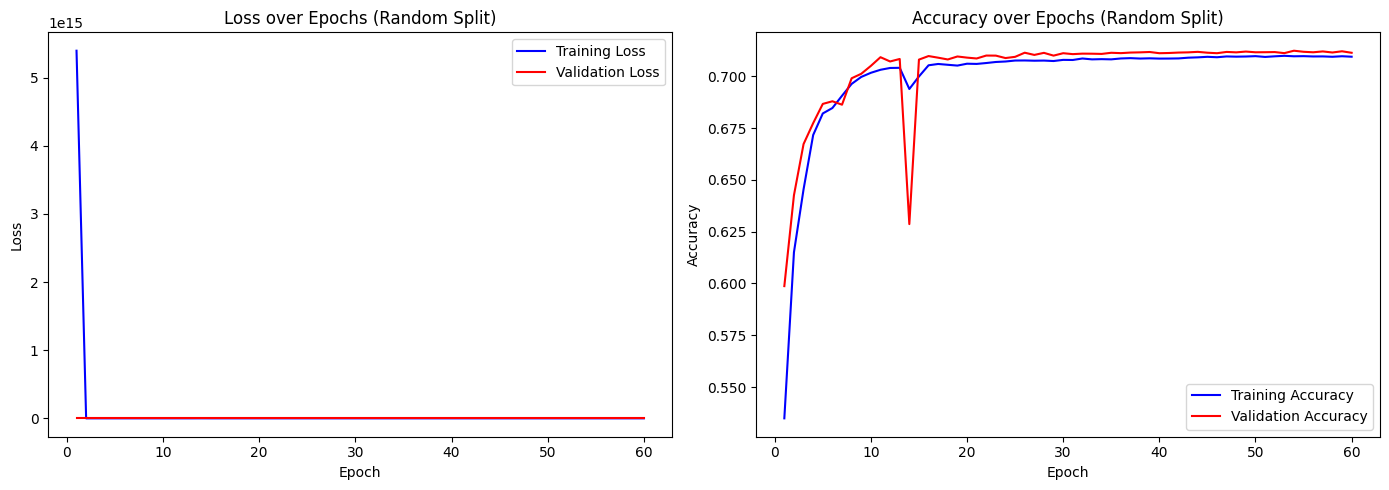

In [76]:
acc = history_random.history['accuracy']
val_acc = history_random.history['val_accuracy']
loss = history_random.history['loss']
val_loss = history_random.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(epochs, loss, 'b-', label='Training Loss')
axs[0].plot(epochs, val_loss, 'r-', label='Validation Loss')
axs[0].set_title('Loss over Epochs (Random Split)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b-', label='Training Accuracy')
axs[1].plot(epochs, val_acc, 'r-', label='Validation Accuracy')
axs[1].set_title('Accuracy over Epochs (Random Split)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


# 12: Evaluate CNN on Random Split (Test Set)


912/912 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Test Metrics (Random Split):
Accuracy : 0.7108
Precision: 0.6698
Recall   : 0.7798
F1 Score : 0.7206


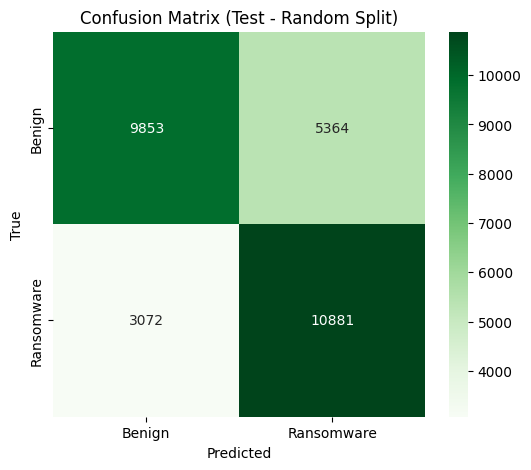

In [77]:

y_test_random_pred_proba = cnn_model_random.predict(X_test_random_cnn).ravel()
y_test_random_pred = (y_test_random_pred_proba >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test_random, y_test_random_pred)
test_precision = precision_score(y_test_random, y_test_random_pred)
test_recall = recall_score(y_test_random, y_test_random_pred)
test_f1 = f1_score(y_test_random, y_test_random_pred)

print("Test Metrics (Random Split):")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1 Score : {test_f1:.4f}")

cm_random = confusion_matrix(y_test_random, y_test_random_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_random, annot=True, fmt='d', cmap='Greens', xticklabels=['Benign', 'Ransomware'], yticklabels=['Benign', 'Ransomware'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test - Random Split)")
plt.show()


In this notebook, we experimented with using a 1D Convolutional Neural Network (CNN) to classify behavioral windows as benign or ransomware. Our dataset consisted of feature vectors extracted from 0.1 second windows of activity, each treated as an independent sample. The initial CNN models were designed to be lightweight and efficient, but the first results were disappointing. The model struggled to generalize, often collapsing to trivial solutions such as predicting only one class.

This led us to perform several experiments to identify what was limiting performance. We tested variations in depth, filter size, and regularization techniques. Specifically, we investigated the effects of Dropout and Batch Normalization. Surprisingly, removing both of these — which are typically beneficial in vision tasks — actually improved performance significantly. We also tested adding L2 regularization and using linear activations instead of ReLU, but neither of these proved useful. In fact, the simplest configuration turned out to be the most effective.

The final model was built without Dropout, Batch Normalization, or L2 regularization. It used three Conv1D layers with kernel size 2, each followed by a ReLU activation. This was followed by a Global Average Pooling layer and two Dense layers before the sigmoid output. The model was trained with a batch size of 128 for up to 60 epochs, with early stopping applied to avoid overfitting.

This configuration achieved the best results of all CNN variants tested. On the random split (where ransomware families were mixed between train and test sets), the model reached an accuracy of about 71% and an F1 score of 72%. On the much more difficult family-aware split, where entire ransomware families were held out of the training set, the model achieved about 66% accuracy and an F1 score of 71%. These are solid results for a simple CNN, especially considering the challenge of detecting unseen ransomware families.

At the same time, the limitations of this approach became very clear. Although the model was able to learn patterns related to ransomware behavior, its performance was much better on the random split than on the family-aware split. This suggests that CNNs, which are designed to learn local feature patterns, are not ideally suited for this type of data. Behavioral features, unlike image pixels, do not have inherent spatial relationships. Additionally, ransomware behavior tends to unfold over time, and our CNN, working on isolated windows, had no way to capture this temporal dimension.

Overall, this notebook served its purpose very well. It helped us push the CNN as far as it could reasonably go on this problem. We tested multiple architectural decisions, learned what worked and what didn’t, and reached the limits of what a simple CNN could achieve. For further progress and to better capture ransomware family generalization, our next steps will involve models that can learn temporal dependencies explicitly, such as LSTMs or Transformers. CNN will remain part of our toolbox for fast inference or when local pattern learning is sufficient, but moving forward, sequence-aware models are expected to take center stage.